# Определение перспективного тарифа для телекомкомпании

Пользователям предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**План анализа:**

* загрузить данные из файлов 
* провести анализ этих данных (что за данные, какие типы данных, сколько столбцов и строк), определить проблемы с данными.
* провести предобработку данных
* поменять типы данных
* согласно условиям оператора округляем время звонков и интернета до большего целого
* добавить столбец с месяцем, когда производился звонок, отправлялась смс и был выход в интернет
* формируем единую таблицу по месяцам и звонков, интернета и смс
* пишем функцию, которая считаем прибыль по месяцам
* формируем таблицы с тарифами
* считаем дисперсию, стандартное отклонение, среднее по каждому показателю
* строим графики зависимости двух тарифов по всем показателям
* анализ графиков
* строим гипотезу различия двух тарифов
* строим гипотезу различия среднего в Москве и в других районах
* итоговый вывод

##   Изучение данных из файлов

### Изучение данных из файла tariffs

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt
pd.options.display.float_format = '{:.2f}'.format

In [2]:
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data.to_csv('название_датасета.расширение', index=False) 
display(data_tariffs.head())
data_tariffs.info()
data_tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.00,2.00,2.00,2.00,2.00,2.00,2.00
mean,525.00,23040.00,1750.00,1250.00,175.00,2.00,2.00
std,671.75,10861.16,1767.77,989.95,35.36,1.41,1.41
min,50.00,15360.00,500.00,550.00,150.00,1.00,1.00
25%,287.50,19200.00,1125.00,900.00,162.50,1.50,1.50
50%,525.00,23040.00,1750.00,1250.00,175.00,2.00,2.00
75%,762.50,26880.00,2375.00,1600.00,187.50,2.50,2.50
max,1000.00,30720.00,3000.00,1950.00,200.00,3.00,3.00


<div class="alert alert-info">
1. Для удобства переведем мегабайты в гигабайты, чтобы вести все дальнейшие расчеты в ГБ, т.к. сверх тарифа идет стоимость ГБ. 
2. Поменяем название столбца 'rub_monthly_fee' на 'price_month' для удобного чтения и порядок столбцов для наглядности.

In [3]:
data_tariffs['gb_included']=(data_tariffs['mb_per_month_included']/1024).astype('int64')
data_tariffs = data_tariffs.rename(columns={'rub_monthly_fee': 'price_month'})
data_tariffs=data_tariffs[['tariff_name', 'messages_included', 'gb_included', 'minutes_included', 'price_month', 'rub_per_gb', 'rub_per_message', 'rub_per_minute']]
data_tariffs.head()

,tariff_name,messages_included,gb_included,minutes_included,price_month,rub_per_gb,rub_per_message,rub_per_minute
0,smart,50,15,500,550,200,3,3
1,ultra,1000,30,3000,1950,150,1,1


### Изучение данных из файла data_calls

In [4]:
data_calls = pd.read_csv('/datasets/calls.csv')
display(data_calls.head())
data_calls.info()
data_calls.describe()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration,user_id
count,202607.00,202607.00
mean,6.76,1253.94
std,5.84,144.72
min,0.00,1000.00
25%,1.30,1126.00
50%,6.00,1260.00
75%,10.70,1379.00
max,38.00,1499.00


In [5]:
data_calls.query('duration == 0')['duration'].count()

39613

<div class="alert alert-info">
    1. Есть звонки продолжительностью 0 минут, это, скорее всего, неотвеченные, не будем их убирать, они никак не повлияют. 
    2. Пропущенных значений нет. 
    3. Надо перевести время в формат даты, чтобы потом разделить по месяцам. 
    4. Время звонка округлить до целого в большую сторону. 
    5. Добавим столбец с месяцем. 
    6. Переведем время в int. 
    7. Оставим только нужные столбцы - идентиф.пользователя, месяц и время звонка. 8. Сгруппируем полученную таблицу по id пользователя и месяца.

In [6]:
data_calls = data_calls.drop_duplicates() # удалим дубликаты в таблице
data_calls.info() # проверим кол-во оставшихся строк

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 7.7+ MB


In [7]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'].astype('datetime64[M]'))
data_calls['month'] = data_calls['call_date'].dt.month #добавим месяц
data_calls['duration'] = np.ceil(data_calls['duration']).astype('int64') #округляем до целого в большую сторону

In [8]:
display(data_calls.head())
data_calls.info()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-01,0,1000,7
1,1000_1,2018-08-01,0,1000,8
2,1000_2,2018-06-01,3,1000,6
3,1000_3,2018-09-01,14,1000,9
4,1000_4,2018-12-01,6,1000,12


<class 'pandas.core.frame.DataFrame'>
Int64Index: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 9.3+ MB


In [9]:
data_calls=data_calls[['user_id', 'month', 'duration']]
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202607 entries, 0 to 202606
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   202607 non-null  int64
 1   month     202607 non-null  int64
 2   duration  202607 non-null  int64
dtypes: int64(3)
memory usage: 6.2 MB


In [10]:
data_calls_pivot = data_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum').reset_index()     
data_calls_pivot = data_calls_pivot.rename(columns={'duration': 'sum_minut'})
display(data_calls_pivot.head())
data_calls_pivot.info()

,user_id,month,sum_minut
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    3174 non-null   int64
 1   month      3174 non-null   int64
 2   sum_minut  3174 non-null   int64
dtypes: int64(3)
memory usage: 74.5 KB


<div class="alert alert-info">
    1. Данные по звонкам преобразованы 2. Таблица содержит идентиф.пользователя, месяц и сумму минут за месяц. 3. Строки сократились до 3174.

### Изучение данных из файла messages

In [11]:
data_messages = pd.read_csv('/datasets/messages.csv')
display(data_messages.head())
data_messages.info()
data_messages.describe()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,user_id
count,123036.00
mean,1256.99
std,143.52
min,1000.00
25%,1134.00
50%,1271.00
75%,1381.00
max,1499.00


<div class="alert alert-info">
    1. Пропущенных значений нет. 2. Надо перевести время в формат даты, чтобы потом разделить по месяцам. 3. Добавим столбец с месяцем. 4. Сгруппируем полученную таблицу по id пользователя и месяцам.

In [12]:
data_messages = data_messages.drop_duplicates() # удалим дубликаты в таблице
data_messages.info() # проверим кол-во оставшихся строк

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.8+ MB


In [13]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_messages['month'] = data_messages['message_date'].dt.month #добавим месяц
display(data_messages.head())
data_messages.info()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


<class 'pandas.core.frame.DataFrame'>
Int64Index: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.7+ MB


In [14]:
data_messages_pivot = data_messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count').reset_index()     
display(data_messages_pivot.head())
data_messages_pivot.info()

,user_id,month,message_date
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       2717 non-null   int64
 1   month         2717 non-null   int64
 2   message_date  2717 non-null   int64
dtypes: int64(3)
memory usage: 63.8 KB


In [15]:
data_messages_pivot = data_messages_pivot.rename(columns={'message_date': 'sum_message'}) #поменяем название для удобства
#чтобы название соответствовало содержимому
data_messages_pivot.head()

,user_id,month,sum_message
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


<div class="alert alert-info">
    1. Данные по кол-ву сообщений преобразованы 2. Таблица содержит идентиф.пользователя, месяц и кол-во сообщений за месяц по каждому абоненту. 3. Строки сократились до 2717.

### Изучение данных из файла internet

In [16]:
data_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
display(data_internet.head())
data_internet.info()
data_internet.describe()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,mb_used,user_id
count,149396.00,149396.00
mean,370.19,1252.10
std,278.30,144.05
min,0.00,1000.00
25%,138.19,1130.00
50%,348.01,1251.00
75%,559.55,1380.00
max,1724.83,1499.00


<div class="alert alert-info">
    1. Пропущенных значений нет. 2. Надо перевести время в формат даты, чтобы потом разделить по месяцам. 3. Добавим столбец с месяцем. 4. Интернет переведем в ГБ, т.к. перерасход начисляется за гигабайты и преобразуем в int с округлением в большую сторону. 5. Сгруппируем полученную таблицу по id пользователя и месяцам.

In [17]:
data_internet = data_internet.drop_duplicates() # удалим дубликаты в таблице
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_internet['month'] = data_internet['session_date'].dt.month #добавим месяц

data_internet['gb_used']=data_internet['mb_used'] / 1024

data_internet.head()

,id,mb_used,session_date,user_id,month,gb_used
0,1000_0,112.95,2018-11-25,1000,11,0.11
1,1000_1,1052.81,2018-09-07,1000,9,1.03
2,1000_2,1197.26,2018-06-25,1000,6,1.17
3,1000_3,550.27,2018-08-22,1000,8,0.54
4,1000_4,302.56,2018-09-24,1000,9,0.30


In [18]:
data_internet=data_internet[['user_id', 'month', 'gb_used']]
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  149396 non-null  int64  
 1   month    149396 non-null  int64  
 2   gb_used  149396 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 4.6 MB


In [19]:
data_internet_pivot = data_internet.pivot_table(index=['user_id', 'month'], values='gb_used', aggfunc='sum').reset_index()
data_internet['gb_used'] = np.ceil(data_internet['gb_used']).astype('int64')
display(data_internet_pivot.head())
data_internet_pivot.info()

,user_id,month,gb_used
0,1000,5,2.20
1,1000,6,22.69
2,1000,7,13.68
3,1000,8,13.73
4,1000,9,14.23


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  3203 non-null   int64  
 1   month    3203 non-null   int64  
 2   gb_used  3203 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 75.2 KB


In [20]:
data_internet_pivot = data_internet_pivot.rename(columns={'gb_used': 'sum_gb'}) #поменяем название,
#чтобы соответствовало содержанию
data_internet_pivot['sum_gb'] = np.ceil(data_internet_pivot['sum_gb'])
data_internet_pivot.head()

,user_id,month,sum_gb
0,1000,5,3.00
1,1000,6,23.00
2,1000,7,14.00
3,1000,8,14.00
4,1000,9,15.00


<div class="alert alert-info">
1. Данные по кол-ву ГБ преобразованы 2. Таблица содержит идентиф.пользователя, месяц и кол-во ГБ за месяц по каждому абоненту. 3. Строки сократились до 3203.

### Изучение данных из файла users

In [21]:
data_users = pd.read_csv('/datasets/users.csv')
display(data_users.head())
data_users.info()
data_users.describe()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age
count,500.00,500.00
mean,1249.50,46.59
std,144.48,16.67
min,1000.00,18.00
25%,1124.75,32.00
50%,1249.50,46.00
75%,1374.25,62.00
max,1499.00,75.00


<div class="alert alert-info">
    1. Есть пропущенные значения в дате прекращения тарифа, т.к. большинство тарифов еще действовало. 2. Оставляем только нужные для анализа столбцы - идентиф.абонента, тариф и город.

In [22]:
data_users=data_users[['user_id', 'tariff', 'city']]
data_users = data_users.drop_duplicates() # удалим дубликаты в таблице

display(data_users.head())
data_users.info()

,user_id,tariff,city
0,1000,ultra,Краснодар
1,1001,smart,Москва
2,1002,smart,Стерлитамак
3,1003,ultra,Москва
4,1004,ultra,Новокузнецк


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  500 non-null    int64 
 1   tariff   500 non-null    object
 2   city     500 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.6+ KB


## Объединение таблиц

**Объединим таблицы звонков и сообщений**

In [23]:
data=data_calls_pivot.merge(data_messages_pivot, on=['user_id', 'month'], how='outer')
display(data.head())
data.info()

,user_id,month,sum_minut,sum_message
0,1000,5,159.00,22.00
1,1000,6,172.00,60.00
2,1000,7,340.00,75.00
3,1000,8,408.00,81.00
4,1000,9,466.00,57.00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3212
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      3213 non-null   int64  
 1   month        3213 non-null   int64  
 2   sum_minut    3174 non-null   float64
 3   sum_message  2717 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 125.5 KB


**Объединим полученную таблицу с таблицей интернета**

In [24]:
data=data.merge(data_internet_pivot, on=['user_id', 'month'], how='outer')
display(data.head())
data.info()

,user_id,month,sum_minut,sum_message,sum_gb
0,1000,5,159.00,22.00,3.00
1,1000,6,172.00,60.00,23.00
2,1000,7,340.00,75.00,14.00
3,1000,8,408.00,81.00,14.00
4,1000,9,466.00,57.00,15.00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      3214 non-null   int64  
 1   month        3214 non-null   int64  
 2   sum_minut    3174 non-null   float64
 3   sum_message  2717 non-null   float64
 4   sum_gb       3203 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 150.7 KB


**Объединим полученную таблицу с таблицей абонентов**

In [25]:
data=data.merge(data_users, on=['user_id'], how='outer')
display(data.head())
data.info()

,user_id,month,sum_minut,sum_message,sum_gb,tariff,city
0,1000,5.00,159.00,22.00,3.00,ultra,Краснодар
1,1000,6.00,172.00,60.00,23.00,ultra,Краснодар
2,1000,7.00,340.00,75.00,14.00,ultra,Краснодар
3,1000,8.00,408.00,81.00,14.00,ultra,Краснодар
4,1000,9.00,466.00,57.00,15.00,ultra,Краснодар


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      3216 non-null   int64  
 1   month        3214 non-null   float64
 2   sum_minut    3174 non-null   float64
 3   sum_message  2717 non-null   float64
 4   sum_gb       3203 non-null   float64
 5   tariff       3216 non-null   object 
 6   city         3216 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 201.0+ KB


<div class="alert alert-info">
    В итоговой таблице есть попущенные значения и float - Заменим отсутствующие значения на 0 и переведем количественные столбцы в int

In [26]:
data = data.fillna(0)
data = data.astype(
    {
        'sum_message':'int',
        'sum_minut':'int',
        'month':'int',
        }
)

data=data.query('month > 0')

In [27]:
display(data.head())
data.info()

,user_id,month,sum_minut,sum_message,sum_gb,tariff,city
0,1000,5,159,22,3.00,ultra,Краснодар
1,1000,6,172,60,23.00,ultra,Краснодар
2,1000,7,340,75,14.00,ultra,Краснодар
3,1000,8,408,81,14.00,ultra,Краснодар
4,1000,9,466,57,15.00,ultra,Краснодар


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      3214 non-null   int64  
 1   month        3214 non-null   int64  
 2   sum_minut    3214 non-null   int64  
 3   sum_message  3214 non-null   int64  
 4   sum_gb       3214 non-null   float64
 5   tariff       3214 non-null   object 
 6   city         3214 non-null   object 
dtypes: float64(1), int64(4), object(2)
memory usage: 200.9+ KB


<div class="alert alert-info">
    Итоговая таблица преобразована - В ней содержится вся информация по минутам, сообщениям и гигабайтам, по каждому абоненту ежемесячно.

## Помесячная выручка с каждого пользователя

In [28]:
data_tariffs.head() #вспомним условия каждого тарифа

,tariff_name,messages_included,gb_included,minutes_included,price_month,rub_per_gb,rub_per_message,rub_per_minute
0,smart,50,15,500,550,200,3,3
1,ultra,1000,30,3000,1950,150,1,1


In [29]:
def price(df):
    sum_minut = df['sum_minut']
    sum_message = df['sum_message']
    sum_gb = df['sum_gb']
    tariff = df['tariff']
    if tariff == 'smart':
        if sum_minut > 500:
            price_min=(sum_minut-500)*3 #стоимость минут потраченных сверх тарифа
        else:
            price_min = 0
        if sum_message > 50:
            price_message=(sum_message-50)*3 #стоимость сообщений потраченных сверх тарифа
        else:
            price_message = 0
        if sum_gb > 15:
            price_gb=(sum_gb-15)*200 #стоимость гб потраченных сверх тарифа
        else:
            price_gb = 0
        return price_min + price_message + price_gb + 550 #цена за месяц: тариф + потраченное сверху
    elif tariff == 'ultra':
        if sum_minut > 3000:
            price_min=sum_minut-3000 #стоимость минут потраченных сверх тарифа
        else:
            price_min = 0
        if sum_message > 1000:
            price_message=sum_message-1000 #стоимость сообщений потраченных сверх тарифа
        else:
            price_message = 0
        if sum_gb > 30:
            price_gb=(sum_gb-30)*150 #стоимость гб потраченных сверх тарифа
        else:
            price_gb = 0
        return price_min + price_message + price_gb + 1950 #цена за месяц: тариф + потраченное сверху
            
  
   
data['price_month'] =  data.apply(price, axis=1) #новый столбец, функцию ко всей строке

In [30]:
display(data.head()) #проверим результат
data.info()

,user_id,month,sum_minut,sum_message,sum_gb,tariff,city,price_month
0,1000,5,159,22,3.00,ultra,Краснодар,1950.00
1,1000,6,172,60,23.00,ultra,Краснодар,1950.00
2,1000,7,340,75,14.00,ultra,Краснодар,1950.00
3,1000,8,408,81,14.00,ultra,Краснодар,1950.00
4,1000,9,466,57,15.00,ultra,Краснодар,1950.00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      3214 non-null   int64  
 1   month        3214 non-null   int64  
 2   sum_minut    3214 non-null   int64  
 3   sum_message  3214 non-null   int64  
 4   sum_gb       3214 non-null   float64
 5   tariff       3214 non-null   object 
 6   city         3214 non-null   object 
 7   price_month  3214 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 226.0+ KB


## Анализ результатов

In [31]:
data_tariffs.head() #вспоминаем условия тарифов, чтобы сравнить с показателями describe

,tariff_name,messages_included,gb_included,minutes_included,price_month,rub_per_gb,rub_per_message,rub_per_minute
0,smart,50,15,500,550,200,3,3
1,ultra,1000,30,3000,1950,150,1,1


### Анализ тарифа ULTRA

In [32]:
data_ultra=data.query('tariff == "ultra"')
data_ultra.describe()

,user_id,month,sum_minut,sum_message,sum_gb,price_month
count,985.00,985.00,985.00,985.00,985.00,985.00
mean,1263.09,8.25,526.62,49.36,19.49,2070.15
std,140.69,2.87,317.61,47.80,9.85,376.19
min,1000.00,1.00,0.00,0.00,0.00,1950.00
25%,1143.00,6.00,284.00,6.00,12.00,1950.00
50%,1277.00,9.00,518.00,38.00,19.00,1950.00
75%,1381.00,11.00,752.00,79.00,27.00,1950.00
max,1495.00,12.00,1673.00,224.00,49.00,4800.00


In [33]:
user_ultra_30 = data_ultra.query('sum_gb>30')['sum_gb'].count()
user_ultra_30 

134

In [34]:
user_ultra_30 / 985

0.13604060913705585

<div class="alert alert-info">
В тариф УЛЬТРА входит 1000 сообщений, 30 гб, 3000 минут, абонет.плата - 1950р.
Максимальное кол-во в месяц сообщений было 224, минут 1673, что не превышает лимит. - А максимальное кол-во гб в месяц было 49, 75% пользователей укладываются в лимит - Средний ежемесячный чек - 2070р., что почти равно абоненской плате. 14% наблюдений превышает лимит интернета в 30 ГБ

In [35]:
data_ultra.head()

,user_id,month,sum_minut,sum_message,sum_gb,tariff,city,price_month
0,1000,5,159,22,3.00,ultra,Краснодар,1950.00
1,1000,6,172,60,23.00,ultra,Краснодар,1950.00
2,1000,7,340,75,14.00,ultra,Краснодар,1950.00
3,1000,8,408,81,14.00,ultra,Краснодар,1950.00
4,1000,9,466,57,15.00,ultra,Краснодар,1950.00


#### Анализ ULTRA - минуты

In [36]:
variance = np.var(data_ultra['sum_minut'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', data_ultra['sum_minut'].mean())

Дисперсия -  100873.63339730098
Отклонение -  317.6060978591264
Среднее -  526.6233502538071


Text(0.5, 1.0, 'Анализ минут УЛЬТРА')

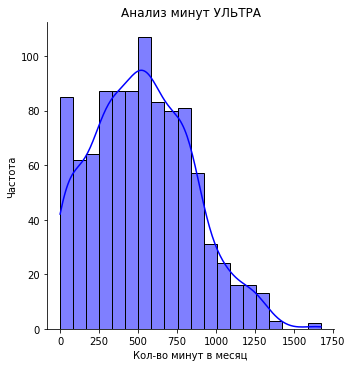

In [37]:
sns.displot(data_ultra['sum_minut'], kde=True,
             bins=20, color = 'blue')

plt.xlabel("Кол-во минут в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y
plt.title("Анализ минут УЛЬТРА")

<div class="alert alert-info">
Распределение скошено влево, распределение мультимодальное - Половина абонентов используют до 500 минут в месяц из возможных 3000 минут и 25% абонентов пользуются только 9% минут от лимита. - Часть пользователей минимально пользуются минутами, другие приложения с помощью интернета заменяют связь.

#### Анализ ULTRA - сообщения

Text(0.5, 1.0, 'Анализ сообщений УЛЬТРА')

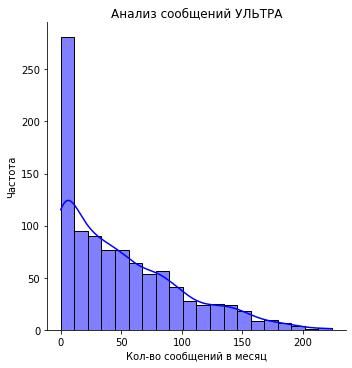

In [38]:
sns.displot(data_ultra['sum_message'], kde=True, 
             bins=20, color = 'blue')


plt.xlabel("Кол-во сообщений в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y
plt.title('Анализ сообщений УЛЬТРА')

In [39]:
variance = np.var(data_ultra['sum_message'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', data_ultra['sum_message'].mean())

Дисперсия -  2285.2661425446736
Отклонение -  47.804457350174715
Среднее -  49.36345177664975


<div class="alert alert-info">
Распределение скошено влево, 50% абонентов используют в месяц до 38 сообщений, что около 4% от лимита. - 25% абонентов отправляют до 6 сообщений в месяц, что меньше 1% от лимита, на графике это выглядит как выброс. - обычные сообщения часто заменяются телеграмом, ватсапом и др, т.е. посредством интернета. - сообщения меньше всего интересуют клиентов. 

#### Анализ ULTRA - интернет

In [40]:
variance = np.var(data_ultra['sum_gb'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', data_ultra['sum_gb'].mean())

Дисперсия -  97.09168626965459
Отклонение -  9.853511367510293
Среднее -  19.494416243654822


Text(0.5, 1.0, 'Анализ интернета УЛЬТРА')

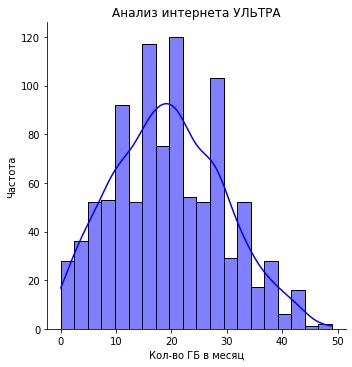

In [41]:
sns.displot(data_ultra['sum_gb'], kde=True, 
             bins=20, color = 'blue')

plt.xlabel("Кол-во ГБ в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y
plt.title('Анализ интернета УЛЬТРА')

<div class="alert alert-info">
    Распределение нормальное, т.к. интернетом пользуются полноценно, звонки и сообщения часто через приложения и соответственно при помощи интернета, больше половины абонентов не превышают лимит.     

In [42]:
gb_ultra=(1-1950*(data_ultra['month'].count()) / data_ultra['price_month'].sum())*100
gb_ultra

5.804031190230985

<div class="alert alert-info">
    Только 6% от выручки по тарифу УЛЬТРА составляет дополнительный интернет      - минуты входят в стоимость, никто из абонентов не тратит доп.минуты, - сообщения входят в стоимость, никто из абонентов не тратит доп.сообщения.

### Анализ тарифа SMART

In [43]:
data_tariffs

,tariff_name,messages_included,gb_included,minutes_included,price_month,rub_per_gb,rub_per_message,rub_per_minute
0,smart,50,15,500,550,200,3,3
1,ultra,1000,30,3000,1950,150,1,1


In [44]:
data_smart=data.query('tariff == "smart"')
data_smart.describe()

,user_id,month,sum_minut,sum_message,sum_gb,price_month
count,2229.00,2229.00,2229.00,2229.00,2229.00,2229.00
mean,1246.51,8.35,417.93,33.38,16.33,1289.97
std,146.12,2.92,190.31,28.23,5.75,818.40
min,1001.00,1.00,0.00,0.00,0.00,550.00
25%,1121.00,6.00,282.00,10.00,13.00,550.00
50%,1239.00,9.00,422.00,28.00,17.00,1023.00
75%,1376.00,11.00,545.00,51.00,20.00,1750.00
max,1499.00,12.00,1435.00,143.00,38.00,6770.00


In [45]:
user_smart_15 = data_smart.query('sum_gb>15')['sum_gb'].count()
user_smart_15

1304

<div class="alert alert-info">
1130 раз был превышен лимит 15 ГБ    

In [46]:
user_smart_15/2229

0.5850157021085689

<div class="alert alert-info">
в 60% наблюдений был превышен лимит 15 ГБ  

In [47]:
user_smart_30 = data_smart.query('sum_gb>30')['sum_gb'].count()
user_smart_30

18

<div class="alert alert-info">
    18 раз был превышен лимит 30 ГБ  

In [48]:
user_smart_30/2229

0.008075370121130552

<div class="alert alert-info">
Всего в 1% наблюдений был превышен лимит 30 ГБ   

<div class="alert alert-info">
В тариф СМАРТ входит 50 сообщений, 15 ГБ, 500 минут, абонент плата - 550 руб.      - 25% абонентов используют доп.сообщения, - Больше 50% абонентов используют дополнительный интернет, - Средний показатель ежемес.объема интернета не превышает лимит. - Более 25% абонентов используют дополнительные минуты. - Средний ежемесячный чек в 2 раза превышает абонентскую плату. - 60% наблюдений - больше 15 ГБ, т.е. вышли за лимит - 1% - больше 30 ГБ, это необходимо для сравнения с поведением абонементов УЛЬТРА     

#### Анализ SMART минуты

In [49]:
variance = np.var(data_smart['sum_minut'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', data_smart['sum_minut'].mean())

Дисперсия -  36219.31578434428
Отклонение -  190.31372988921288
Среднее -  417.9349484073576


Text(0.5, 1.0, 'Анализ минут СМАРТ')

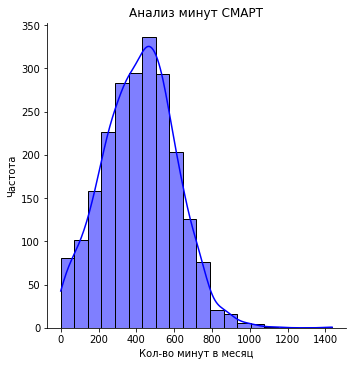

In [50]:
sns.displot(data_smart['sum_minut'], kde=True, 
             bins=20, color = 'blue')

plt.xlabel("Кол-во минут в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y
plt.title('Анализ минут СМАРТ')

<div class="alert alert-info">
Распределение нормальное - Среднее кол-во минут стремится к ежемесячному лимиту и при этом среднее отклонение составляет 35% от лимита - Абоненты не укладываются в лимит, и оплачивают доп.минуты.       

In [51]:
#Посчитаем % отношение выручки от доп.минут к общей выручке 
min_smart=data_smart.query('sum_minut > 500')['sum_minut'].sum() - data_smart.query('sum_minut > 500')['sum_minut'].count() * 500
print(min_smart) #кол-во дополнительных минут
((min_smart*3)/data_smart['price_month'].sum())*100

92739


9.675931738420806

<div class="alert alert-info">
Выручка от доп.минут составляет 10% ко всей выручке по тарифу      

In [52]:
#Посчитаем % отношение выручки от доп.минут к выручке по абон.плате (2229 абонетов по 550 руб.)   
min_smart=data_smart.query('sum_minut > 500')['sum_minut'].sum() - data_smart.query('sum_minut > 500')['sum_minut'].count() * 500
print(min_smart) #кол-во дополнительных минут
(min_smart*3)/(2229*550)

92739


0.2269399241404625

<div class="alert alert-info">
Выручка от доп.минут составляет 23% к абоненской плате 

#### Анализ SMART сообщения

In [53]:
variance = np.var(data_smart['sum_message'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', data_smart['sum_message'].mean())

Дисперсия -  796.8129584480083
Отклонение -  28.22787555676141
Среднее -  33.384028712427096


Text(0.5, 1.0, 'Анализ сообщений СМАРТ')

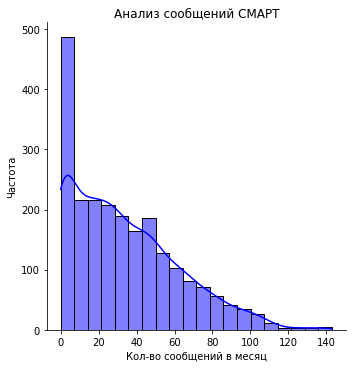

In [54]:
sns.displot(data_smart['sum_message'], kde=True, 
             bins=20, color = 'blue')

plt.xlabel("Кол-во сообщений в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y
plt.title('Анализ сообщений СМАРТ')

<div class="alert alert-info">
Распределение скошено влево - 25% от всех месяцев использовали менее 10 сообщений, при наличии интернета сообщения становятся менее востребованными. - 75% - укладывались в лимит 50 сообщений - и только 25% пользовались доп.сообщениями. - Среднее немного больше среднего по лимиту (т.е. 25 сообщений из 50) - И с учетом отклонения 28, большая часть наблюдений укладывается в лимит.   

In [55]:
mess_smart=data_smart.query('sum_message > 50')['sum_message'].sum() - data_smart.query('sum_message > 50')['sum_message'].count() * 50
print(mess_smart) #кол-во дополнительных сообщений
(mess_smart*3)/(2229*550)

12928


0.03163587421999266

<div class="alert alert-info">
Выручка от доп.сообщений составляет 3% к абонентской плате  

In [56]:
mess_smart=data_smart.query('sum_message > 50')['sum_message'].sum() - data_smart.query('sum_message > 50')['sum_message'].count() * 50
print(mess_smart) #кол-во дополнительных сообщений
((mess_smart*3)/data_smart['price_month'].sum())*100

12928


1.348844019391024

<div class="alert alert-info">
Выручка от доп.сообщений составляет 1,5% ко всей выручке по тарифу     

#### Анализ SMART интернет

In [57]:
variance = np.var(data_smart['sum_gb'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', data_smart['sum_gb'].mean())

Дисперсия -  33.02870517811161
Отклонение -  5.7470605685090534
Среднее -  16.328847016599372


Text(0.5, 1.0, 'Анализ интернета СМАРТ')

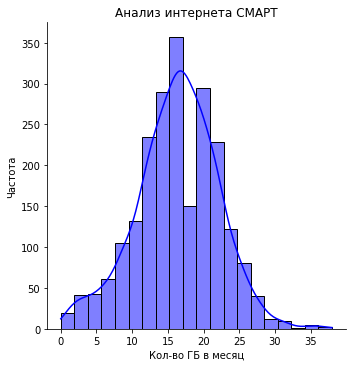

In [58]:
sns.displot(data_smart['sum_gb'], kde=True, 
             bins=20, color = 'blue')

plt.xlabel("Кол-во ГБ в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y
plt.title('Анализ интернета СМАРТ')

<div class="alert alert-info">
Распределение нормальное - 15 гб входящих в лимит почти среднеге, чуть менее 50% наблюдений укладываются в лимит.

In [59]:
gb_smart=data_smart.query('sum_gb > 15')['sum_gb'].sum() - data_smart.query('sum_gb > 15')['sum_gb'].count() * 15
print(gb_smart) #кол-во дополнительных gb
((gb_smart*200)/data_smart['price_month'].sum())*100

6662.0


46.338690476397495

<div class="alert alert-info">
Выручка от доп.gb интернета составляет 46% ко всей выручке по тарифу    

In [60]:
gb_smart=data_smart.query('sum_gb > 15')['sum_gb'].sum() - data_smart.query('sum_gb > 15')['sum_gb'].count() * 15
print(gb_smart) #кол-во дополнительных gb
(gb_smart*200)/(2229*550)

6662.0


1.0868306211509442

## Проверка гипотез

### Средняя выручка Ультра и Смарт

<div class="alert alert-info">
Средняя выручка по тарифам Ультра и Смарт равны 2070 руб. и 1290 руб. - Предположим что это могло произойти случайно. - Пусть нулевая гипотеза звучит так - средние выручки равны - Альтернативная - не равны   

In [68]:
data

,user_id,month,sum_minut,sum_message,sum_gb,tariff,city,price_month
0,1000,5,159,22,3.00,ultra,Краснодар,1950.00
1,1000,6,172,60,23.00,ultra,Краснодар,1950.00
2,1000,7,340,75,14.00,ultra,Краснодар,1950.00
3,1000,8,408,81,14.00,ultra,Краснодар,1950.00
4,1000,9,466,57,15.00,ultra,Краснодар,1950.00
...,...,...,...,...,...,...,...,...
3209,1489,8,0,17,11.00,smart,Санкт-Петербург,550.00
3210,1489,9,0,32,17.00,smart,Санкт-Петербург,950.00
3211,1489,10,0,21,20.00,smart,Санкт-Петербург,1550.00
3212,1489,11,0,20,18.00,smart,Санкт-Петербург,1150.00


In [61]:
alpha = 0.05

results = sps.ttest_ind(data_ultra['price_month'], data_smart['price_month'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


<div class="alert alert-info">
p-значение достаточно мало, что дает основание отвергнуть предположение об отсутствии различий между выручками у разных тарифных планов.) 

### Средняя выручка Москва и другие города

In [62]:
data.head() #посмотрим какой столбец овечает за город

,user_id,month,sum_minut,sum_message,sum_gb,tariff,city,price_month
0,1000,5,159,22,3.00,ultra,Краснодар,1950.00
1,1000,6,172,60,23.00,ultra,Краснодар,1950.00
2,1000,7,340,75,14.00,ultra,Краснодар,1950.00
3,1000,8,408,81,14.00,ultra,Краснодар,1950.00
4,1000,9,466,57,15.00,ultra,Краснодар,1950.00


In [63]:
print('Уникальные значения в столбце city')
print(data['city'].value_counts())

Уникальные значения в столбце city
Москва             611
Санкт-Петербург    270
Новосибирск         98
Уфа                 95
Краснодар           86
                  ... 
Сургут               6
Нижневартовск        6
Кемерово             5
Химки                5
Иваново              2
Name: city, Length: 76, dtype: int64


<div class="alert alert-info">
Средняя выручка по Москве и др.городам равны 1547 руб. и 1525 руб. - Средние выручки действительно равны, есть небольшое различие - Пусть нулевая гипотеза звучит так - средние выручки равны - Альтернативная - не равны  

In [64]:
data_msk=data.query('city == "Москва"')
data_msk.describe()

,user_id,month,sum_minut,sum_message,sum_gb,price_month
count,611.00,611.00,611.00,611.00,611.00,611.00
mean,1268.87,8.43,469.15,37.88,18.05,1546.71
std,137.53,2.89,241.54,37.16,7.65,752.09
min,1001.00,1.00,0.00,0.00,1.00,550.00
25%,1171.00,6.00,304.00,6.50,13.00,780.50
50%,1291.00,9.00,453.00,29.00,18.00,1750.00
75%,1385.00,11.00,620.50,57.00,22.00,1950.00
max,1490.00,12.00,1321.00,191.00,44.00,5321.00


In [65]:
data_no_msk=data.query('city != "Москва"')
data_no_msk.describe()

,user_id,month,sum_minut,sum_message,sum_gb,price_month
count,2603.00,2603.00,2603.00,2603.00,2603.00,2603.00
mean,1247.53,8.29,447.04,38.38,17.12,1524.94
std,146.01,2.91,241.85,35.91,7.33,808.79
min,1000.00,1.00,0.00,0.00,0.00,550.00
25%,1120.00,6.00,280.50,9.50,13.00,750.00
50%,1241.00,9.00,440.00,30.00,17.00,1583.00
75%,1377.00,11.00,584.00,57.00,21.00,1950.00
max,1499.00,12.00,1673.00,224.00,49.00,6770.00


In [66]:
alpha = 0.05

results = sps.ttest_ind(data_msk['price_month'], data_no_msk['price_month'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-info">
С вероятностью 54 % небольшое различие можно получить случайно.     

## Общий вывод

<div class="alert alert-info">

Краткий обзор проведённой работы: 

1. Данные со звонками, сообщениями и интернетом, пользователями не содержали пропущенных значений, дубликатов не было. В таблице звонков была продолжительность 0.0 минут, это неотвеченные звонки , не имеет смысла их убирать, т.к. для анализа суммируем сумму минут за месяц. 
2. Было проанализировано два тарифа Смарт и Ультра. - В СМАРТ входит 50 сообщений, 500 минут, 15 ГБ, абон.плата – 550 руб. - В УЛЬТРА входит 1000 сообщений, 3000 минут, 30 ГБ, абон.плата – 1950 руб. 

Анализ тарифов сотового оператора: 
1. Абоненты в обоих тарифах используют интернет значительно больше лимита. - В Ультра в среднем – 20 ГБ, максимально – 49 ГБ. - 12% из всех месяцев у абонентов УЛЬТРА был превышен лимит ГБ, т.е. было более 30 ГБ - В Смарте в среднем – 16 ГБ, максимально – 38 ГБ. - 50% из всех месяцев у абонентов СМАРТ - больше 15 ГБ, т.е. вышли за лимит - 0,5% из всех месяцев абоненты СМАРТ использовали более 30 ГБ. 
2. Т.е. в лимиты обоих тарифов входит существенная разница по минутам и сообщениям, а интернет отличатся на 15ГБ. Фактически абоненты обоих тарифов тратят похожее кол-во минут, сообщений абоненты Ультра тратят в среднем немного больше. А интернет абоненты Смарта тратят больше и при этом он для них по более дорогой цене. Более 0,5% месяцев по тарифу Смарт превышают лимит ГБ в два раза, т.е. за дополнительные 15 ГБ платят 3000. А это значит, что эти 0,5% - как минимум приносят оператору 3550 рублей при тех же условиях что и тариф УЛЬТРА. Т.е. вместо 1950 получается 3550. А если еще рассмотреть превышение 30 ГБ, то для сотового оператора абоненты Смарта становятся еще более выгодными, ведь они платят по 200 руб. за ГБ, а Ультра 150 руб. за ГБ. 
3. Доп.минуты от абонентов Смарт также приносят прибыль сотовому оператору, а именно 22% от выручке по абон.плате. Средняя выручка от абонента в месяц: - УЛЬТРА – 2050 руб. - СМАРТ – 1173 руб. 
Анализ тарифов и проверка гипотез показывает, что различие это не случайное, а закономерное. Поведение пользователей двух тарифов мало отличается , а расценки разные, отсюда и разность в выручке. Средняя выручка по Москве и другим регионам практически не отличается. 

Рекомендации:
1. Оставить тариф "Ультра" и привлекать потребителей к данному тарифу, поскольку он приносит максимальную выручку из двух вариантов.

2. Незначительно уменьшить стоимость сверхлимитного использования минут разговора и отправки сообщений в тарифе "Ультра", поскольку это может привлечь ещё больше потребителей. Однако не следует рассматривать дополнительную плату за эти опции как дополнительный доход, поскольку пользователи способны уложиться в установленные лимиты.

3. При неизменной стоимости дополнительных опций уменьшить лимиты в тарифе "Ультра": минуты разговора до 1 500, количество сообщений до 200.

4. Региональная политика оператора должна быть идентичной, так как Москва и другие города приносят идентичную среднюю выручку в рамках тарифа.